# Task 0: Import libraries and dataframe

In [1]:
import pandas as pd
import numpy as np
x = 2

In [29]:
df = pd.read_csv("results.csv")


# Task one: Mean home/away_scores

In [14]:
print(df['home_score'].mean())
print(df['away_score'].mean())

1.7430011723329426
1.1848300117233295


# Task two: total_score col added and plotted in Histogram

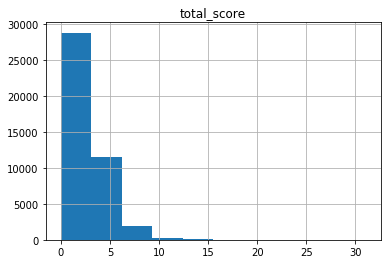

In [27]:
df['total_score'] = df['home_score'] + df['away_score']
df_hist = df.hist(column='total_score')

# Task two: home_team win percent 

In [40]:
win = np.where(df['home_score'] > df['away_score'], 'win', None)
tie = np.where(df['home_score'] == df['away_score'], 'tie', None)
loss = np.where(df['home_score'] < df['away_score'], 'loss', None)

results = pd.DataFrame([win,tie,loss]).T

x = [value[value != None] for value in results.values]

df['result'] = x
df['result'] = np.squeeze(df.result.tolist())

In [41]:
results.values

array([[None, 'tie', None],
       ['win', None, None],
       ['win', None, None],
       ...,
       ['win', None, None],
       ['win', None, None],
       ['win', None, None]], dtype=object)

In [39]:
df['result'].value_counts('win') * 100

win     48.626026
loss    28.309496
tie     23.064478
Name: result, dtype: float64

# Task four: Which country scored the most goals during FIFA events

In [46]:
tournament = ['FIFA World Cup','FIFA World Cup qualification']
dfx = df.copy()
dfx = dfx.loc[dfx['tournament'].isin(tournament)]
dfx

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
1314,1930-07-13,Belgium,United States,0,3,FIFA World Cup,Montevideo,Uruguay,True,loss
1315,1930-07-13,France,Mexico,4,1,FIFA World Cup,Montevideo,Uruguay,True,win
1316,1930-07-14,Brazil,Yugoslavia,1,2,FIFA World Cup,Montevideo,Uruguay,True,loss
1317,1930-07-14,Peru,Romania,1,3,FIFA World Cup,Montevideo,Uruguay,True,loss
1318,1930-07-15,Argentina,France,1,0,FIFA World Cup,Montevideo,Uruguay,True,win
...,...,...,...,...,...,...,...,...,...,...
42645,2021-09-09,Colombia,Chile,3,1,FIFA World Cup qualification,Barranquilla,Colombia,False,win
42646,2021-09-09,Paraguay,Venezuela,2,1,FIFA World Cup qualification,Asunción,Paraguay,False,win
42647,2021-09-09,Uruguay,Ecuador,1,0,FIFA World Cup qualification,Montevideo,Uruguay,False,win
42648,2021-09-09,Argentina,Bolivia,3,0,FIFA World Cup qualification,Buenos Aires,Argentina,False,win


In [52]:
home = dfx[['home_team', 'home_score']].rename(
    columns={'home_team': 'team', 'home_score':'score'})

away = dfx[['away_team', 'away_score']].rename(
    columns={'away_team':'team', 'away_score': 'score'})

team_score = home.append(away).reset_index(drop=True)

country_info = team_score.groupby('team')['score'].agg(['sum']).reset_index()

country_max = country_info.sort_values(['team','sum'], ascending=True)
country_max = country_max.set_index('team')
country_max.sort_values(by=(['sum']), ascending=False).head(15)

,sum
team,
Germany,535
Brazil,483
Mexico,454
Netherlands,404
Australia,394
Spain,388
Argentina,387
England,384
Belgium,366


# Task five: Which country is mostlikely to win the next FIFA event?

In [56]:
dfx = dfx.reset_index()


0         Belgium
1          France
2          Brazil
3            Peru
4       Argentina
          ...    
8512     Colombia
8513     Paraguay
8514      Uruguay
8515    Argentina
8516       Brazil
Name: home_team, Length: 8517, dtype: object

In [62]:
#Home team
home_teams = dfx.groupby(['home_team','result']).count()['city'].sort_values(ascending=False).reset_index().rename(columns={'city': 'count'})

home_matches = []
for team in home_teams.home_team:
    tot_matches = home_teams[home_teams['home_team'] == team]['count'].sum()
    home_matches.append(tot_matches)

home_teams['home_matches'] = home_matches
home_teams['pct_home_win'] = home_teams['count']/ home_teams['home_matches']

#Away team
away_teams = dfx.groupby(['away_team','result']).count()['city'].sort_values(ascending=False).reset_index().rename(columns={'city': 'count'})
away_teams.replace({'loss': 'win', 'win':'loss'}, inplace=True) 

away_tot_matches = []
for team in away_teams.away_team:
    tot_matches = away_teams[away_teams.away_team == team]['count'].sum()
    away_tot_matches.append(tot_matches)

away_teams['away_matches'] = away_tot_matches
away_teams['pct_away_win'] = away_teams['count']/away_teams['away_matches']

#Tweaks
home_teams.rename(columns={'result': 'home_results', 'count': 'home_count'}, inplace=True)
home_teams.set_index('home_team', inplace=True)

away_teams.rename(columns={'result': 'away_results', 'count': 'away_count'}, inplace=True)
away_teams.set_index('away_team', inplace=True)

#Winners and losers
home_winners = home_teams[home_teams.home_results == 'win']
away_winners = away_teams[away_teams.away_results == 'win']
home_losers = home_teams[home_teams.home_results == 'loss']
away_losers = away_teams[away_teams.away_results == 'loss']

#Merging dataframes
winners = pd.merge(home_winners, away_winners, left_index=True, right_index=True, how ='inner')
losers = pd.merge(home_losers, away_losers, left_index=True, right_index=True, how ='inner')
losers.rename(columns={'pct_home_win': 'pct_home_loss', 'pct_away_win': 'pct_away_loss'}, inplace=True)

#Winners
winners['tot_count'] = winners.home_count + winners.away_count
winners['tot_matches'] = winners.home_matches + winners.away_matches
winners['tot_pct_win'] = winners.tot_count/winners.tot_matches

winners_pct = winners[['pct_home_win', 'pct_away_win', 'tot_pct_win']]

#Losers
losers['tot_count'] = losers.home_count + losers.away_count
losers['tot_matches'] = losers.home_matches + losers.away_matches
losers['tot_pct_loss'] = losers.tot_count/losers.tot_matches

losers_pct = losers[['pct_home_loss', 'pct_away_loss', 'tot_pct_loss']]

#Total win percentage
winners_pct = np.round(winners_pct*100, 2)
winners_pct['tot_count'] = winners.tot_count
winners_pct['tot_matches'] = winners.tot_matches

losers_pct = np.round(losers_pct*100, 2)
losers_pct['tot_count'] = losers.tot_count
losers_pct['tot_matches'] = losers.tot_matches

winners_pct.sort_values(by='tot_pct_win', ascending=False).head(10)

,pct_home_win,pct_away_win,tot_pct_win,tot_count,tot_matches
Germany,69.29,70.73,69.86,146,209
Brazil,71.13,55.95,65.49,148,226
Netherlands,67.37,56.98,62.43,113,181
Italy,70.09,52.75,62.12,123,198
Spain,68.89,55.21,61.83,115,186
China PR,69.35,48.28,59.17,71,120
England,68.09,49.46,58.82,110,187
Russia,76.62,42.05,58.18,96,165
Iran,64.56,47.89,56.67,85,150
Croatia,62.50,50.98,56.04,51,91


In [69]:
from scipy.stats import ttest_ind_from_stats


In [72]:

#home stats
home1 = np.mean(np.array(df['home_score']))
homestd = np.std(np.array(df['home_score']), ddof=1)
homen = len(np.array(df['home_score']))

#away stats
away1 = np.mean(np.array(df['away_score']))
awaystd = np.std(np.array(df['away_score']), ddof=1)
awayn = len(np.array(df['away_score']))

stat, p = ttest_ind_from_stats(home1,homestd,homen,away1,awaystd,awayn)
print('t=%.3f, p=%.3f' % (stat,p))
alpha = 0.5
if p > alpha:
    print('not significant')
if p < alpha:
    print('is significant')

t=51.353, p=0.000
is significant
